In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):
    policy = np.ones(action_n) * epsilon / action_n
    max_action = np.argmax(q_values)
    policy[max_action] += 1 - epsilon
    return np.random.choice(np.arange(action_n), p=policy)


def MonteCarlo(env, episode_n, trajectory_len=500, gamma=0.99):
    total_rewards = []

    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    counter = np.zeros((state_n, action_n))

    for episode in range(episode_n):
        epsilon = 1 - episode / episode_n
        trajectory = {'states': [], 'actions': [], 'rewards': []}

        state = env.reset()
        for _ in range(trajectory_len):
            trajectory['states'].append(state)

            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
            trajectory['actions'].append(action)

            state, reward, done, _ = env.step(action)
            trajectory['rewards'].append(reward)

            if done:
                break

        total_rewards.append(sum(trajectory['rewards']))

        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]

        for t in range(real_trajectory_len):
            state = trajectory['states'][t]
            action = trajectory['actions'][t]
            qfunction[state][action] += (returns[t] - qfunction[state][action]) / (1 + counter[state][action])
            counter[state][action] += 1

    return total_rewards


In [5]:
def SARSA(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)

    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))

    for episode in range(episode_n):
        epsilon = 1 / (episode + 1)

        state = env.reset()
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)

            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][next_action] - qfunction[state][action])

            state = next_state
            action = next_action

            total_rewards[episode] += reward

            if done:
                break

    return total_rewards

In [7]:
def QLearning(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)

    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))

    for episode in range(episode_n):
        epsilon = 1 / (episode + 1)

        state = env.reset()
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)

            max_q = max(qfunction[next_state])
            qfunction[state][action] += alpha * (reward + gamma * max_q - qfunction[state][action])

            state = next_state
            action = next_action

            total_rewards[episode] += reward

            if done:
                break

    return total_rewards


In [14]:
class CEM:
    def __init__(self, env, q_param: float):
        self.state_n = env.observation_space.n
        self.action_n = env.action_space.n
        self.q_param = q_param
        self.policy = np.ones((self.state_n, self.action_n)) / self.action_n

    def get_action(self, state):
        return int(np.random.choice(np.arange(self.action_n), p=self.policy[state]))

    def update_policy(self, elite_trajectories):
        pre_policy = np.zeros((self.state_n, self.action_n))

        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                pre_policy[state][action] += 1

        for state in range(self.state_n):
            if sum(pre_policy[state]) == 0:
                self.policy[state] = np.ones(self.action_n) / self.action_n
            else:
                self.policy[state] = pre_policy[state] / sum(pre_policy[state])

        return None

    def get_trajectory(self, trajectory_len):
        trajectory = {'states': [], 'actions': [], 'total_reward': 0}

        state = env.reset()
        trajectory['states'].append(state)

        for _ in range(trajectory_len):

            action = self.get_action(state)
            trajectory['actions'].append(action)

            state, reward, done, _ = env.step(action)
            trajectory['total_reward'] += reward

            if done:
                break

            trajectory['states'].append(state)

        return trajectory

    def get_elite_trajectories(self, trajectories):
        total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
        quantile = np.quantile(total_rewards, q=self.q_param)
        return [trajectory for trajectory in trajectories if
                trajectory['total_reward'] > quantile]

    def fit(self, episode_n, trajectory_n, trajectory_len):
        total_rewards = []

        for i in range(episode_n):
            trajectories = [self.get_trajectory(trajectory_len) for _ in range(trajectory_n)]

            mean_total_reward = np.mean(
                [trajectory['total_reward'] for trajectory in trajectories])
            total_rewards.append(mean_total_reward)

            elite_trajectories = self.get_elite_trajectories(trajectories)

            if len(elite_trajectories) > 0:
                self.update_policy(elite_trajectories)
        return total_rewards


In [25]:
env = gym.make("Taxi-v3")

result = {}
cem = CEM(env, q_param=0.3)
result['cem'] = cem.fit(episode_n=2000, trajectory_n=100, trajectory_len=1000)
result['qlearn'] = QLearning(env, episode_n=2000, trajectory_len=1000, gamma=0.999, alpha=0.5)
result['sarsa'] = SARSA(env, episode_n=2000, trajectory_len=1000, gamma=0.999, alpha=0.5)
result['monte_carlo'] = MonteCarlo(env, episode_n=2000, trajectory_len=1000, gamma=0.99)
result.keys()

dict_keys(['cem', 'qlearn', 'sarsa', 'monte_carlo'])

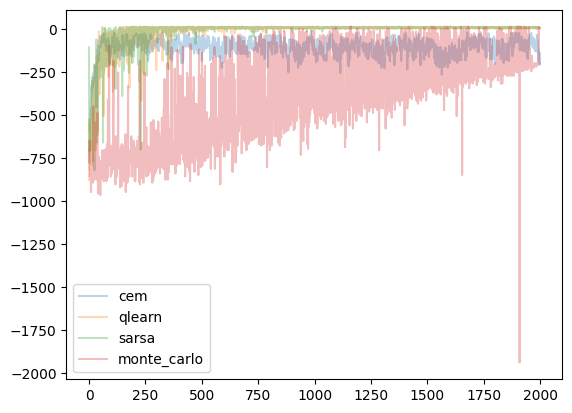

In [26]:
for key in result:
    plt.plot(result[key], label=key, alpha=0.3)
plt.legend()
plt.show()